#   **Capstone Project - Battle of Neighborhoods**




## **1) Problem Description:**
One of my clients mentioned to me that they are planning to setup an **Indo Chinese** restaurant in Chicago. However, since he is not from Chicago, he wanted me to do some analysis on the different neighborhoods in Chicago and recommend 2 neighborhoods where he will have greater chances of succeeding if he sets up his restaurant. He was open to suburbs and the downtown areas of Chicago. Based on the recommendation, he will perform a physical feasibility study and make his decision. These recommendations will speed his time to entry into the Chicago market.

This type of analysis will be useful to any business trying to expand into other markets and doesn’t want to nor have the necessary local presence or intelligence to make a Go or No-Go decision based on the local market data. 

## 2) **Data Description**
The data for performing the explorations come from the following sources:

*   **Chicago neighborhood dataset** - https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago . This data will help us analyze and group neighborhoods based on the community areas.
*   **Location Data from Foursquare** - for each neighborhood venues and venues categories were gathered for analysis, narrowing down of the neighborhoods to top 5 and clustering. In addition we can get a granular view of the types of businesses in these neighborhoods.











In [1]:
# import the necessary libraries and toolsets

import pandas as pd # library for data analsysis
import numpy as np # library to handle data 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import os
import folium # map rendering library
import random # library for random number generation
from IPython.display import display_html
import lxml

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp

import re
import csv
%matplotlib inline

##### Create some helper functions that get the required data based on the neighborhood information we pass.

In [10]:
# create some functions to make our job easier
def get_geo_loc(address):
    # get geo location of address
    geo_locator = Nominatim(user_agent="Chicago_explorer")
    location = geo_locator.geocode(address)
    if location is not None:
          lat = location.latitude
          lon = location.longitude
    elif location is None:
          lat = 41.8781   #default location of Chicago
          lon = 87.6298
    return lat,lon

In [2]:
# Get venue information based on the Location info from FourSquare
def get_venues_from_4S(lat,lon):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'XVXWHBOTEHKY23WZHQ0YDBXFO0UMCDEW2TQM1US1PQZZU42B'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='4GZ1YRPDJMAVJLIVI25WEL45VUQT1GQGSF400UHCXL4PDBB2' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [3]:
 # Get venue detail information based on the venue ID from FourSquare
 def get_venue_details_from_4S(venue_id):

    CLIENT_ID = 'XVXWHBOTEHKY23WZHQ0YDBXFO0UMCDEW2TQM1US1PQZZU42B'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='4GZ1YRPDJMAVJLIVI25WEL45VUQT1GQGSF400UHCXL4PDBB2' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
# Get the nearby venue information within in a certain radius based on the address and Location info from FourSquare

def getNearbyVenues_from_4S(names, latitudes, longitudes, radius=500):
    CLIENT_ID = 'XVXWHBOTEHKY23WZHQ0YDBXFO0UMCDEW2TQM1US1PQZZU42B'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='4GZ1YRPDJMAVJLIVI25WEL45VUQT1GQGSF400UHCXL4PDBB2' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

##### **Data gathering and processing**

In [6]:
# perform web scrapping, use BeautifulSoup to parse and beautify the raw xml data
source = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago').text
xml_data=BeautifulSoup(source,'lxml')
#print(soup.title)
from IPython.display import display_html
chicago_data_table = str(xml_data.table)
display_html(chicago_data_table,raw=True)

Neighborhood,Community area
Albany Park,Albany Park
Altgeld Gardens,Riverdale
Andersonville,Edgewater
Archer Heights,Archer Heights
Armour Square,Armour Square
Ashburn,Ashburn
Ashburn Estates,Ashburn
Auburn Gresham,Auburn Gresham
Avalon Park,Avalon Park
Avondale,Avondale


In [7]:
# Convert the raw html data into a dataframe
chicago_df = pd.read_html(chicago_data_table)
codes_df=chicago_df[0]
codes_df.head(5)

,Neighborhood,Community area
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


In [8]:
codes_df.shape

(246, 2)

##### Get location information and add it to the DataFrame

In [12]:
# determine the lat and long and add it to the dataframe. Since it is a 3rd party API call, if hte service times out, retry again.
neigh_list = []
lat_long_list = []
lat_list= []
long_list = []
comm_list = []

for n in codes_df['Neighborhood'] :
  comm_list.append(n)

for i in range(len(comm_list)):
  ll = get_geo_loc(comm_list[i])
  lat_long_list.append(ll)

lat_list, long_list = map(list, zip(*lat_long_list))

In [13]:
# create a new dataframe that will have 3 columns
ll_df1 = pd.DataFrame({'Neighborhood' : comm_list, 'Latitude' : lat_list ,'Longitude' : long_list })
ll_df1.shape

(246, 3)

##### Merge the neighborhood information with location information

In [17]:
# Merge Neighborhood and Lat/Long dataframes
chicago_df = pd.merge(codes_df, ll_df1, on=['Neighborhood'])
chicago_df.head()

,Neighborhood,Community area,Latitude,Longitude
0,Albany Park,Albany Park,41.971937,-87.716174
1,Altgeld Gardens,Riverdale,41.654864,-87.600446
2,Andersonville,Edgewater,32.195995,-84.139909
3,Archer Heights,Archer Heights,41.811422,-87.726165
4,Armour Square,Armour Square,41.840033,-87.633107


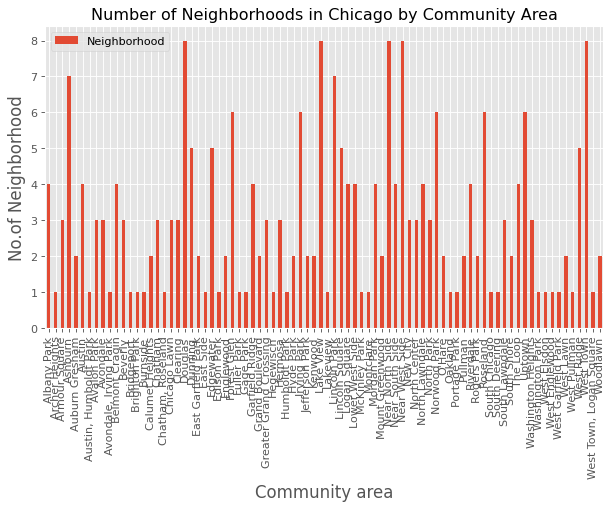

In [18]:
# Plot the bar chart of the neighborhoods grouped by community area
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighborhoods in Chicago by Community Area')
#On x-axis
plt.xlabel('Community', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
chicago_df.groupby('Community area')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

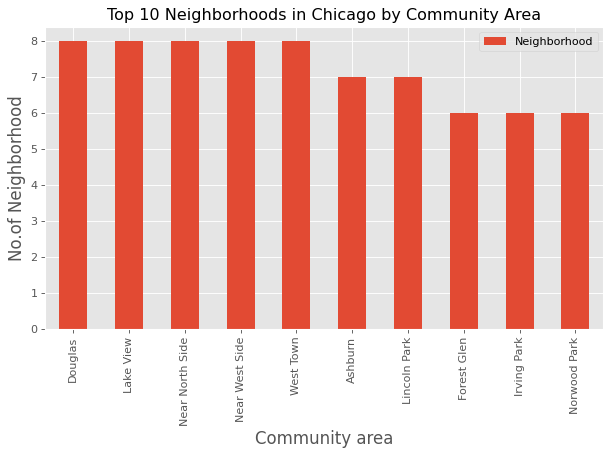

In [20]:
# draw the top 10 neighborhoods
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Top 10 Neighborhoods in Chicago by Community Area')
#On x-axis
plt.xlabel('Community', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
chicago_df.groupby('Community area')['Neighborhood'].count().nlargest(10).plot(kind='bar')

#legend
plt.legend()
plt.show()

In [21]:
chicago_df.groupby('Community area')['Neighborhood'].count().nlargest(8)

Community area
Douglas            8
Lake View          8
Near North Side    8
Near West Side     8
West Town          8
Ashburn            7
Lincoln Park       7
Forest Glen        6
Name: Neighborhood, dtype: int64

In [22]:
#loop through the Neighborhoods to see which have the highest number of venues

community_list = ['Douglas','Lake View','Near North Side','Near West Side','West Town', 'Ashburn', 'Lincoln Park', 'Forest Glen']

venues_count = getNearbyVenues_from_4S(names=community_list,latitudes=chicago_df['Latitude'],longitudes=chicago_df['Longitude'])
venues_count

Found 66 venues in 8 neighborhoods.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Douglas,41.971937,-87.716174,Chicago Produce,41.970553,-87.716327,Grocery Store
1,Douglas,41.971937,-87.716174,Cairo Nights Hookah Lounge,41.975776,-87.715547,Hookah Bar
2,Douglas,41.971937,-87.716174,Nighthawk,41.967974,-87.713415,Cocktail Bar
3,Douglas,41.971937,-87.716174,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
4,Douglas,41.971937,-87.716174,Popeyes Louisiana Kitchen,41.968756,-87.713019,Fried Chicken Joint
5,Douglas,41.971937,-87.716174,Banpojung,41.975707,-87.715609,Korean Restaurant
6,Douglas,41.971937,-87.716174,Markellos Baking Company,41.968602,-87.716607,Bakery
7,Douglas,41.971937,-87.716174,Subway,41.968748,-87.712861,Sandwich Place
8,Douglas,41.971937,-87.716174,T-Mobile,41.968751,-87.713158,Mobile Phone Shop
9,Douglas,41.971937,-87.716174,Dunkin',41.968255,-87.712964,Donut Shop


In [23]:
venues_count.groupby('Neighborhood').count() # group venues by Neighborhood

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ashburn,10,10,10,10,10,10
Douglas,14,14,14,14,14,14
Forest Glen,5,5,5,5,5,5
Lake View,2,2,2,2,2,2
Lincoln Park,3,3,3,3,3,3
Near North Side,5,5,5,5,5,5
Near West Side,14,14,14,14,14,14
West Town,13,13,13,13,13,13


In [24]:
#drop_labels=['Neighborhood Latitude','Neighborhood Longitude']
# Narrow down to top 4 neighborhoods
com_list=['Near West Side','Douglas','West Town','Ashburn']
near_west_side_venues = getNearbyVenues_from_4S(names=com_list,latitudes=chicago_df['Latitude'],longitudes=chicago_df['Longitude'])
#near_west_side_venues=near_west_side_venues.drop(labels=drop_labels,axis=1)
near_west_side_venues.head(10)

Found 35 venues in 4 neighborhoods.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Near West Side,41.971937,-87.716174,Chicago Produce,41.970553,-87.716327,Grocery Store
1,Near West Side,41.971937,-87.716174,Cairo Nights Hookah Lounge,41.975776,-87.715547,Hookah Bar
2,Near West Side,41.971937,-87.716174,Nighthawk,41.967974,-87.713415,Cocktail Bar
3,Near West Side,41.971937,-87.716174,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
4,Near West Side,41.971937,-87.716174,Popeyes Louisiana Kitchen,41.968756,-87.713019,Fried Chicken Joint
5,Near West Side,41.971937,-87.716174,Banpojung,41.975707,-87.715609,Korean Restaurant
6,Near West Side,41.971937,-87.716174,Markellos Baking Company,41.968602,-87.716607,Bakery
7,Near West Side,41.971937,-87.716174,Subway,41.968748,-87.712861,Sandwich Place
8,Near West Side,41.971937,-87.716174,T-Mobile,41.968751,-87.713158,Mobile Phone Shop
9,Near West Side,41.971937,-87.716174,Dunkin',41.968255,-87.712964,Donut Shop


In [25]:
print('There are {} distinct venues in {} categories.'.format(
    len(near_west_side_venues['Venue'].unique()),len(near_west_side_venues['Venue Category'].unique())))

There are 33 distinct venues in 26 categories.


In [26]:
# now lets analyze each neighborhood
# one hot encoding
#venues_onehot = pd.get_dummies(venues_count[['Venue Category']], prefix="", prefix_sep="")
venues_onehot = pd.get_dummies(near_west_side_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#venues_onehot['Neighborhood'] = venues_count['Neighborhood'] 
venues_onehot['Neighborhood'] = near_west_side_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Neighborhood,American Restaurant,Bakery,Bank,Bar,Big Box Store,Burger Joint,Bus Station,Chinese Restaurant,Cocktail Bar,Coffee Shop,Donut Shop,Fried Chicken Joint,Gas Station,Grocery Store,Gym / Fitness Center,History Museum,Hookah Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Mobile Phone Shop,Park,Post Office,Sandwich Place,Wings Joint
0,Near West Side,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Near West Side,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Near West Side,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Near West Side,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Near West Side,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped

,Neighborhood,American Restaurant,Bakery,Bank,Bar,Big Box Store,Burger Joint,Bus Station,Chinese Restaurant,Cocktail Bar,Coffee Shop,Donut Shop,Fried Chicken Joint,Gas Station,Grocery Store,Gym / Fitness Center,History Museum,Hookah Bar,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Mexican Restaurant,Mobile Phone Shop,Park,Post Office,Sandwich Place,Wings Joint
0,Ashburn,0.0,0.000000,0.071429,0.071429,0.071429,0.0,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.142857,0.071429,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.0,0.0,0.071429,0.071429
1,Douglas,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000
2,Near West Side,0.0,0.071429,0.000000,0.000000,0.000000,0.0,0.071429,0.071429,0.071429,0.000000,0.071429,0.071429,0.000000,0.142857,0.000000,0.0,0.071429,0.071429,0.071429,0.071429,0.000000,0.071429,0.0,0.0,0.071429,0.000000
3,West Town,0.2,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.2,0.000000,0.000000


In [28]:
# Each neighborhood with the top 8 venues
num_top_venues = 8

for hood in venues_grouped['Neighborhood']:
    print("========= "+hood+" ===========")
    temp = venues_grouped[venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

========= Ashburn ===========
                  venue  freq
0         Grocery Store  0.14
1     Mobile Phone Shop  0.14
2    Mexican Restaurant  0.14
3           Coffee Shop  0.07
4        Sandwich Place  0.07
5  Gym / Fitness Center  0.07
6           Gas Station  0.07
7           Wings Joint  0.07


========= Douglas ===========
                       venue  freq
0                       Park   1.0
1        American Restaurant   0.0
2                     Bakery   0.0
3             Sandwich Place   0.0
4                Post Office   0.0
5          Mobile Phone Shop   0.0
6         Mexican Restaurant   0.0
7  Latin American Restaurant   0.0


========= Near West Side ===========
                venue  freq
0       Grocery Store  0.14
1          Hookah Bar  0.07
2      Sandwich Place  0.07
3   Mobile Phone Shop  0.07
4         Bus Station  0.07
5  Chinese Restaurant  0.07
6        Cocktail Bar  0.07
7          Donut Shop  0.07


========= West Town ===========
                  venue  fre

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Ashburn,Mobile Phone Shop,Mexican Restaurant,Grocery Store,Wings Joint,Gym / Fitness Center,Bank,Bar,Big Box Store
1,Douglas,Park,Wings Joint,Fried Chicken Joint,Bakery,Bank,Bar,Big Box Store,Burger Joint
2,Near West Side,Grocery Store,Hookah Bar,Karaoke Bar,Bus Station,Donut Shop,Fried Chicken Joint,Sandwich Place,Chinese Restaurant
3,West Town,History Museum,American Restaurant,Post Office,Burger Joint,Fried Chicken Joint,Bakery,Bank,Bar


In [38]:
neighborhoods_venues_sorted.shape

(4, 9)

In [39]:
# Cluster the Near West Side Neighborhood using k-means
# Run K-means to cluster neighborhood into three clusters

# import k-means from clustering stage
from sklearn.cluster import KMeans

kclusters = 3

venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)
#venues_grouped_clustering = near_west_side_venues.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 0, 2], dtype=int32)

In [33]:
nvs = neighborhoods_venues_sorted

coords = [get_geo_loc("Ashburn, Chicago"),get_geo_loc("Douglas, Chicago"),get_geo_loc("Near West Side"),get_geo_loc("West Town")]
df_coords = pd.DataFrame(coords,columns=['Latitude','Longitude'])
df_coords.head()

,Latitude,Longitude
0,41.747533,-87.711163
1,41.834857,-87.617954
2,41.880066,-87.666762
3,41.901421,-87.686166


In [34]:
nvs_1 = pd.concat([neighborhoods_venues_sorted,df_coords], axis=1)
nvs_1['Cluster Labels'] = kmeans.labels_
nvs_1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Latitude,Longitude,Cluster Labels
0,Ashburn,Mobile Phone Shop,Mexican Restaurant,Grocery Store,Wings Joint,Gym / Fitness Center,Bank,Bar,Big Box Store,41.747533,-87.711163,0
1,Douglas,Park,Wings Joint,Fried Chicken Joint,Bakery,Bank,Bar,Big Box Store,Burger Joint,41.834857,-87.617954,1
2,Near West Side,Grocery Store,Hookah Bar,Karaoke Bar,Bus Station,Donut Shop,Fried Chicken Joint,Sandwich Place,Chinese Restaurant,41.880066,-87.666762,0
3,West Town,History Museum,American Restaurant,Post Office,Burger Joint,Fried Chicken Joint,Bakery,Bank,Bar,41.901421,-87.686166,2


In [35]:
map_clusters = folium.Map(location=get_geo_loc("Chicago"), zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(nvs_1['Latitude'], 
                                   nvs_1['Longitude'], 
                                   nvs_1['Neighborhood'], 
                                   nvs_1['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### **Results and Recommendation Summary:**
After I ran the k-means clustering on the data and added the clusters to the data frame I wanted to map out all the different clusters to get a nice visualization of the similar neighborhoods.Based on the above map, it looks like the clusters are centered around the 2 neighborhoods - Near West Side and Ashburn. As part of improving the granularity of the clusters, I would recommend expanding the top "n" neighborhoods from 8 to 15 and increasing the venue from top 8 to top 12. This would bring in additional data points that will increase the granularity of the data. Another dimension that will help us further narrow down the 2 locations is the "sentiment" analysis data such as Tips and recommendation data from Foursquare. 

### **Conclusion:**
Based on the number of neighborhoods, the number of venues within these neighborhoods and the number of variety of venues in the venues, I would recommend the 2 best places to start a new resturaunt business is in the "Near West Side" and "Ashburn" neighborhoods. As additional support the venues details indicate that there are not that many resturants these areas, which provides a good probability of success for my client succeed if they open a resturant in these neighborhoods.
